# **PERFORMANCE EVALUATION CLASS BY CLASS**
In this paper, given a query for each class, we are going to see the 10-NN results. In this way we are going to see which class is approximate better, considering the score too. This is done either using the **predefined model** and the **finetuned model**, then we compare the performance.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install import-ipynb
%cd "/content/gdrive/MyDrive/progetto/code/"

Mounted at /content/gdrive
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=c187e59c8ab4037dba73e69c240cf5e48a447f61c041620cb666f6a3c6ac7c3d
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/gdrive/MyDrive/progetto/code


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.models import load_model
import os
import pickle
import import_ipynb
import ipywidgets as ip 
from LSH_Index import *
import tensorflow as tf
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
import PIL 
from PIL import ImageDraw, ImageOps, Image
import numpy as np
import time

BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')
test_path = "/content/gdrive/MyDrive/progetto/pickles/testing_image_features.npy"
test_labels_path = "/content/gdrive/MyDrive/progetto/pickles/testing_image_labels.npy"
finetuned_test_labels_path = "/content/gdrive/MyDrive/progetto/pickles/testing_image_labels_finetuning.npy"
finetuned_test_features_path = "/content/gdrive/MyDrive/progetto/pickles/testing_image_features_finetuning.npy"
pick_path_normal= '/content/gdrive/MyDrive/progetto/pickles/lsh_models/definitive/predefined(4,4).pickle'
pick_path_tuned = '/content/gdrive/MyDrive/progetto/pickles/lsh_models/definitive/finetuned(5,5).pickle'

np.random.seed(42)
tf.random.set_seed(42)

importing Jupyter notebook from LSH_Index.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here we load both LSH indexes previously performed and saved as pickle. **LSHtuned** is the index obtained by using finetuned network, while **LSHnormal** is the index obtained by using predefined model.

In [ ]:
#Loading LSHIndex for the tuned model
LSHtuned = pickle.load(open(pick_path_tuned,"rb"))
#Loading LSHIndex for the predefined model
LSHnormal = pickle.load( open(pick_path_normal, "rb" ) )

Our *search()* function performed with **lsh index** returns a list in which there are the lists of ids, labels and distances. This utility function allows to divide the lists mentioned above.

In [ ]:
def create_from_results(results):
  labels = []
  distances = []
  ids = []
  for r in results:
    ids.append(r[0])
    labels.append(r[1])
    distances.append(r[2])
  return labels,distances,ids

Now we load test's features extracted both with the finetuned network and with the predefined network. We take an image for each labels.

In [ ]:
n_queries = 7

test_images_tuned = np.load(  finetuned_test_features_path  )
test_labels_tuned = np.load( finetuned_test_labels_path )

test_images_normal = np.load( test_path )
test_labels_normal = np.load( test_labels_path )

query_indexes = [3340,509,3150,721,1420,242,2510]

'''
ind = 0
while ind != n_queries:
   query_ind = np.random.choice(len(test_images_tuned),replace=False)
   if test_labels_tuned[query_ind] not in test_labels_tuned[query_indexes]:
     query_indexes.append(query_ind)
     ind += 1
   else:
     continue
'''
query_images_normal = test_images_normal[query_indexes]
query_labels_normal = test_labels_normal[query_indexes]
query_images_tuned = test_images_tuned[query_indexes]
query_labels_tuned = test_labels_tuned[query_indexes]


With this snippet of code, we take the filename of each image belonging to our dataset. This is done to print the image in the following.

In [ ]:
dirs = sorted(os.listdir(TEST_DATA_DIR))
filenames=[]
directories=[]
for dir in dirs:
  fn= os.listdir(os.path.join(TEST_DATA_DIR,dir))
  for i in range(len(fn)):
    directories.append(dir)
  filenames.extend(fn)

## **Query**

First we build the path of the images used as query with their filenames and with the directory from which belong. Once we have obtained the path, we are able to display the queries with their belonging class. Query images belong to test set.

In [ ]:
preview_size = 80

def construct_images_queries(images, dirs):
  imgs=[]
  for im,d in zip(images,dirs):
    filepath = os.path.join(os.path.join(TEST_DATA_DIR,d), im)
    image = np.array(load_img(str(filepath), target_size=(preview_size,preview_size,3)))
    imgs.append(image)
  return imgs

def show_queries(images, labels):
  imgs = construct_images_queries(images, labels)
  for i in range(len(imgs)):
    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')
    # draw score
    draw = ImageDraw.Draw(imgs[i])
    draw.text((3, 80 - 12), f'{labels[i]}', anchor='lt', fill="red")
    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 5, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])
  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally
  display(Image.fromarray(image)) 

## **Results**

With the `compute_ap_at_k(...,...)` function, we perform the **average precision** of the result of each query. Then we perform the same step performed previously for the query, but using images belonging to the training set as results: first we build the path of the images and then we show them. For each query, we show the *k-NN results* (in this case k=10).



In [ ]:
def compute_ap_at_k(ranked_relevance, k):
  print(f'Ranked relvance: {ranked_relevance}')
  #ranked_relevance is a boolean array of dim k. true if retrieved element is relevant for the query, false if not relevant 
  total_relevant_items = ranked_relevance.sum()
  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  #cumsum [1,3,2]=>[1,4,6]
  prec_at_i = ranked_relevance.cumsum() / np.arange(1, k + 1) 
  # sum of prec_at_i only for relevant, divide for total number of relevant items 
  aps =  (ranked_relevance * prec_at_i).sum() / ( total_relevant_items + np.finfo(float).eps )
  print(f'APS: {aps}') 
  return aps

def construct_images(images, labels):
  imgs=[]
  for im,la in zip(images,labels):
    folder = ''
    if la == 0:
      folder = 'Angry'
    elif la == 1:
      folder = 'Disgust'
    elif la == 2:
      folder = 'Fear'
    elif la == 3:
      folder = 'Happy'
    elif la == 4:
      folder = 'Neutral'
    elif la == 5:
      folder = 'Sad'
    elif la == 6:
      folder = 'Surprise'
    elif la == 7:
      folder = 'Z_mirflickr'   
    filepath = os.path.join(os.path.join(TRAIN_DATA_DIR,folder), im)
    image = np.array(load_img(str(filepath), target_size=(preview_size,preview_size,3)))
    imgs.append(image)
  return imgs     

# utility function to draw knn results for multiple queries
def show_results(images, labels, scores, ranked_relevance):
  imgs = construct_images(images, labels)
  for i in range(len(imgs)):
    # add a red/green flag
    color = (0, 255, 0) if ranked_relevance[i] else (255, 0, 0)
    flag = np.full((4, 80, 3), fill_value=color, dtype=imgs[i].dtype)
    imgs[i] = np.concatenate((imgs[i], flag), axis=0)
    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')
    # draw score
    draw = ImageDraw.Draw(imgs[i])
    if(ranked_relevance[i]==0):
      draw.text((3, 80 - 12), f'{scores[i]:.2f}', anchor='lt', fill=color)
    else:
      draw.text((3, 80 - 12), f'{scores[i]:.2f}', anchor='lt', fill=color)
    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 5, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])
  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally
  display(Image.fromarray(image))

As we said before, we perform a *k-NN search*. We pass the index to the function to obtain the results either with the predefined network and with the finetuned network, because we want to see if there is or not an improvement.

In [ ]:
def evaluate_knn_search(lsh_index,query_features, query_labels, db_features, db_labels, g, h, k=None):
  aps = []
  for i in range(len(query_features)):
    # get the entire db as result list (for computing mAP)
    startTime = time.perf_counter()
    results = lsh_index.search(query_features[i], g, h, 10)
    processTime = time.perf_counter() - startTime
    ranked_labels,ranked_score,ids = create_from_results(results)
    print(f'The label of the query is: {query_labels[i]}')
    print(f"The result is: {ids}\n{ranked_labels}")
    print(f'Query answered in: {processTime} s')
    # ranked_relevance = whether the retrieved image is relevant w.r.t. the query
    ranked_relevance= []
    for label in ranked_labels:
      if query_labels[i] == label:
        res = 1
      else:
        res = 0
      ranked_relevance.append(res)
    ranked_relevance = np.array(ranked_relevance)
    ap_k = compute_ap_at_k(ranked_relevance, len(ranked_relevance))
    aps.append(ap_k)
    show_results(ids, ranked_labels, ranked_score,ranked_relevance)

  print(f'AP@{k} for each Query:', aps)
  print(f'mAP@{k}:', np.mean(aps))


## **Display**
As we can see, the performance obtained with the finetuned model are much better than the ones obtained with the predefined model. We can appreciate an increasing in mAP value:

*   **mAP in predefined model** = 0.28
*   **mAP in finetuned model** = 0.62

In particular, we can see that only the class with label 1 presents one right result in both the situation, the others are all improved.



***Query***
Indexes: [3340, 509, 3150, 721, 1420, 242, 2510]
Labels: (array([6, 1, 5, 2, 3, 0, 4], dtype=int32), ['Surprise', 'Disgust', 'Sad', 'Fear', 'Happy', 'Angry', 'Neutral'])
Filename: ['30049.jpg', '31323.jpg', '32227.jpg', '30028.jpg', '30518.jpg', '30385.jpg', '32273.jpg']


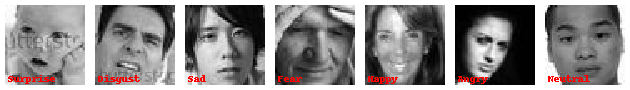


***Model predefined***
The label of the query is: 6
The result is: ['3639.jpg', '7046.jpg', '6219.jpg', '19646.jpg', '26701.jpg', '20128.jpg', '18526.jpg', '4829.jpg', '7931.jpg', '25646.jpg']
[3, 3, 3, 3, 0, 3, 5, 6, 3, 3]
Query answered in: 0.0011449950000042008 s
Ranked relvance: [0 0 0 0 0 0 0 1 0 0]
APS: 0.12499999999999997


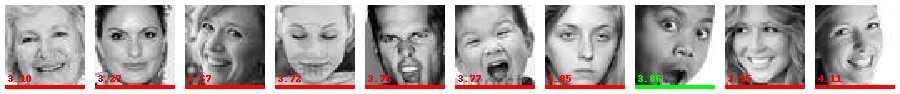

The label of the query is: 1
The result is: ['11941.jpg', '20673.jpg', '21492.jpg', '25434.jpg', '24812.jpg', '8808.jpg', '25829.jpg', '17260.jpg', '9367.jpg', '10150.jpg']
[5, 5, 2, 4, 2, 4, 3, 0, 1, 2]
Query answered in: 0.004797341999960736 s
Ranked relvance: [0 0 0 0 0 0 0 0 1 0]
APS: 0.11111111111111108


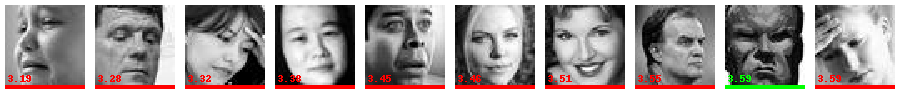

The label of the query is: 5
The result is: ['1423.jpg', '16230.jpg', '19728.jpg', '9263.jpg', '12332.jpg', '24123.jpg', '9462.jpg', '20155.jpg', '14313.jpg', '1250.jpg']
[0, 6, 3, 4, 5, 4, 0, 4, 0, 6]
Query answered in: 0.001285982000013064 s
Ranked relvance: [0 0 0 0 1 0 0 0 0 0]
APS: 0.19999999999999996


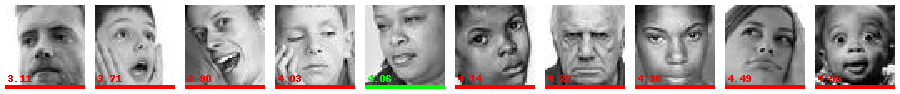

The label of the query is: 2
The result is: ['2275.jpg', '3517.jpg', '9205.jpg', '9766.jpg', '4823.jpg', '20945.jpg', '25902.jpg', '4474.jpg', '22377.jpg', '28612.jpg']
[4, 1, 1, 2, 4, 3, 3, 2, 4, 3]
Query answered in: 0.0022350090000600176 s
Ranked relvance: [0 0 0 1 0 0 0 1 0 0]
APS: 0.25


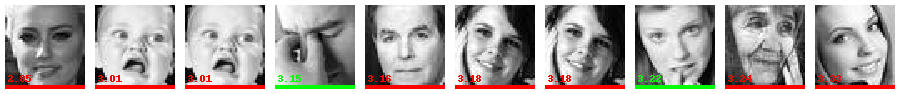

The label of the query is: 3
The result is: ['12709.jpg', '2519.jpg', '24215.jpg', '11455.jpg', '7965.jpg', '10836.jpg', '16945.jpg', '5361.jpg', '24966.jpg', '488.jpg']
[3, 3, 6, 5, 3, 2, 3, 2, 3, 3]
Query answered in: 0.0017081059999100034 s
Ranked relvance: [1 1 0 0 1 0 1 0 1 1]
APS: 0.7211640211640211


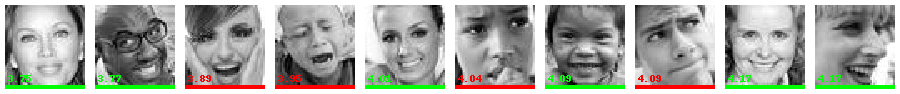

The label of the query is: 0
The result is: ['20522.jpg', '21214.jpg', '4490.jpg', '28691.jpg', '26859.jpg', '2981.jpg', '3851.jpg', '27116.jpg', '9071.jpg', '7392.jpg']
[4, 4, 3, 2, 0, 5, 0, 4, 3, 4]
Query answered in: 0.0025338469999951485 s
Ranked relvance: [0 0 0 0 1 0 1 0 0 0]
APS: 0.24285714285714285


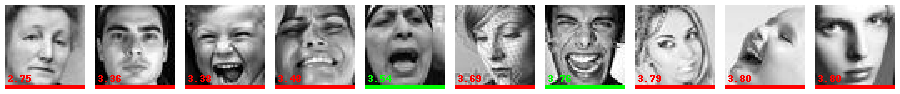

The label of the query is: 4
The result is: ['26907.jpg', '7082.jpg', '114.jpg', '26985.jpg', '2209.jpg', '19922.jpg', '21561.jpg', '18703.jpg', '14586.jpg', '22634.jpg']
[3, 5, 4, 1, 5, 0, 3, 5, 3, 3]
Query answered in: 0.0021844850000434235 s
Ranked relvance: [0 0 1 0 0 0 0 0 0 0]
APS: 0.33333333333333326


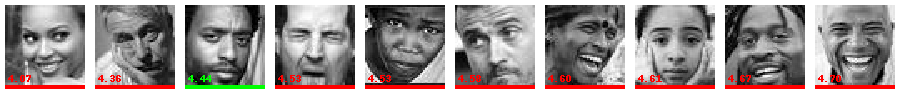

AP@10 for each Query: [0.12499999999999997, 0.11111111111111108, 0.19999999999999996, 0.25, 0.7211640211640211, 0.24285714285714285, 0.33333333333333326]
mAP@10: 0.28335222978080116

***Model finetuned***
The label of the query is: 6
The result is: ['14464.jpg', '6215.jpg', '20692.jpg', '12288.jpg', '17502.jpg', '10250.jpg', '13877.jpg', '18437.jpg', '1726.jpg', '20039.jpg']
[6, 2, 6, 6, 5, 6, 6, 6, 6, 2]
Query answered in: 0.0028596130000551057 s
Ranked relvance: [1 0 1 1 0 1 1 1 1 0]
APS: 0.7607709750566893


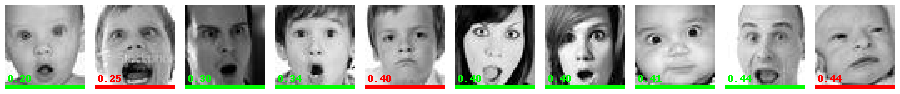

The label of the query is: 1
The result is: ['25025.jpg', '12856.jpg', '16387.jpg', '22691.jpg', '13224.jpg', 'im7701.jpg', '20664.jpg', '11146.jpg', '27344.jpg', '4178.jpg']
[0, 0, 1, 5, 0, 7, 0, 5, 5, 5]
Query answered in: 0.001961086000051182 s
Ranked relvance: [0 0 1 0 0 0 0 0 0 0]
APS: 0.33333333333333326


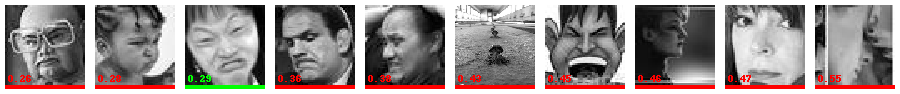

The label of the query is: 5
The result is: ['26190.jpg', '15933.jpg', '24882.jpg', '20343.jpg', '3186.jpg', 'im12571.jpg', '15333.jpg', '22325.jpg', 'im2638.jpg', 'im11099.jpg']
[4, 4, 5, 5, 5, 7, 4, 3, 7, 7]
Query answered in: 0.0043311879999237135 s
Ranked relvance: [0 0 1 1 1 0 0 0 0 0]
APS: 0.4777777777777777


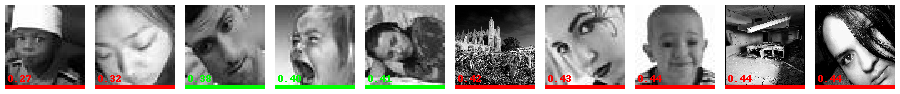

The label of the query is: 2
The result is: ['10872.jpg', '12093.jpg', '28400.jpg', '23356.jpg', '13079.jpg', '15835.jpg', '7143.jpg', '16861.jpg', '14723.jpg', 'im22199.jpg']
[5, 5, 4, 2, 2, 2, 0, 4, 2, 7]
Query answered in: 0.002330363000055513 s
Ranked relvance: [0 0 0 1 1 1 0 0 1 0]
APS: 0.3986111111111111


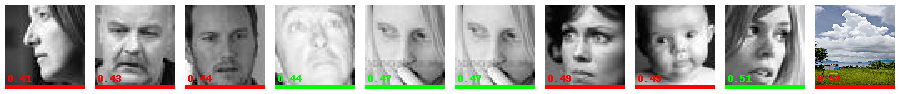

The label of the query is: 3
The result is: ['7013.jpg', '6247.jpg', '4118.jpg', '15867.jpg', '12407.jpg', '6451.jpg', '27590.jpg', '5955.jpg', '6445.jpg', '16767.jpg']
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Query answered in: 0.0025177850000090984 s
Ranked relvance: [1 1 1 1 1 1 1 1 1 1]
APS: 1.0


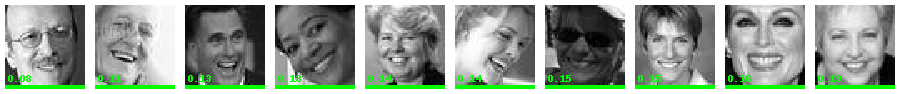

The label of the query is: 0
The result is: ['21284.jpg', '15373.jpg', '20454.jpg', '15279.jpg', '19812.jpg', '26730.jpg', '5188.jpg', '12116.jpg', '10471.jpg', 'im18756.jpg']
[0, 2, 2, 0, 0, 0, 0, 1, 2, 7]
Query answered in: 0.0029175629999826924 s
Ranked relvance: [1 0 0 1 1 1 1 0 0 0]
APS: 0.6961904761904762


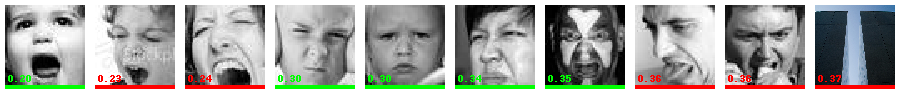

The label of the query is: 4
The result is: ['12473.jpg', '6057.jpg', '18101.jpg', '11282.jpg', '19416.jpg', '17576.jpg', '21889.jpg', '18398.jpg', '9111.jpg', '18029.jpg']
[2, 4, 4, 4, 5, 4, 4, 4, 0, 2]
Query answered in: 0.0010040690000323593 s
Ranked relvance: [0 1 1 1 0 1 1 1 0 0]
APS: 0.6746031746031745


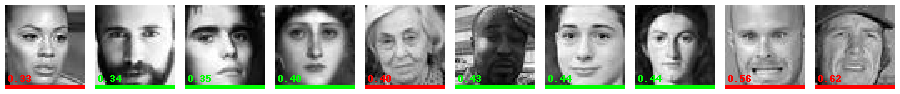

AP@10 for each Query: [0.7607709750566893, 0.33333333333333326, 0.4777777777777777, 0.3986111111111111, 1.0, 0.6961904761904762, 0.6746031746031745]
mAP@10: 0.6201838354389375


In [ ]:
fns = [filenames[i] for i in query_indexes]
dirs = [directories[i] for i in query_indexes]
print('\n***Query***')
print(f'Indexes: {query_indexes}')
print(f'Labels: {query_labels_tuned,dirs}')
print(f'Filename: {fns}')
show_queries(fns,dirs)
print('\n***Model predefined***')
evaluate_knn_search(LSHnormal,query_images_normal, query_labels_normal, test_images_normal, test_labels_normal, 4, 4,10)
print('\n***Model finetuned***')
evaluate_knn_search(LSHtuned,query_images_tuned, query_labels_tuned, test_images_tuned, test_labels_tuned, 5, 5, 10)